In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import utils, io
from dl import authClient as ac, queryClient as qc
from matplotlib import cm
from pyvo.dal import sia
from datalab_utils import *
from smash_utils import *
from getpass import getpass

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
fig_dir = "/dlusers/adriansh/work/analyses/plots/strings/"

In [2]:
def count_stable(df):
    ids = df["id"].unique()
    n = np.array([len(df.loc[df["id"] == oid, "filter"].unique()) for oid in ids])
    return n.sum()

def lens_and_detect(df, bandwidth):
    lens = -2.5 * np.log10(2)
    mags = df["cmag"].values
    errs = df["cerr"].values
    n_samples = len(df)
    result = np.full(n_samples, False)

    for i in range(n_samples):
        z = np.zeros((n_samples,))
        z[i] += lens
        detected = detect_excursions(mags + z, errs, kde_bandwidth=bandwidth)
        result = result | detected

    return result

In [3]:
lmc_center = SkyCoord("05h23m34s", "−69d45.4m")
lmc_ra = lmc_center.ra.deg
lmc_dec = lmc_center.dec.deg
search_radius = .2
n_detections = 5
bandwidths = np.linspace(1 / 6, 2 / 5, num=8) * 2.5 * np.log10(2)

# SMASH
Note that there are 57,774,329 objects matching this query:
SELECT id FROM smash_dr2.object
WHERE id NOT LIKE '%Field%'
AND (ndetu > 5 OR ndetg > 5 OR ndetr > 5 
OR ndeti > 5 OR ndetz > 5)

In [4]:
lightcurve_df = pd.read_feather("/dlusers/adriansh/work/analyses/results/strings/smash_lightcurves.feather")

In [3]:
sub_query = f"""
SELECT id FROM smash_dr2.object
WHERE id NOT LIKE '%Field%'
AND prob > 0.9
AND (ndetu > {n_detections} OR ndetg > {n_detections} OR ndetr > {n_detections} 
OR ndeti > {n_detections} OR ndetz > {n_detections})
LIMIT 10000
"""
# WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {search_radius})


query = f"""
SELECT S.id, S.mjd, S.cmag, S.mag, S.err, S.cerr, S.filter, S.prob,
        S.expnum, S.ra, S.raerr, S.dec, S.decerr, S.chip, E.exptime
    FROM 
        (SELECT *
            FROM smash_dr2.source
                WHERE id IN ({sub_query})) AS S
    INNER JOIN smash_dr2.exposure as E
        ON S.expnum = E.expnum
"""

lightcurve_df = qc.query(sql=query, fmt="pandas")

In [23]:
filters = np.array(['u', 'g', 'r', 'i', 'z'])
mask_filters = np.array([lightcurve_df["filter"] == f for f in filters])
for source_id in lightcurve_df["id"].unique():
    mask_id = lightcurve_df["id"] == source_id
    for mask_filter in mask_filters:
        mask = mask_id & mask_filter
        lc = lightcurve_df.loc[mask]
        for i in range(len(bandwidths)):
            if len(lc) < n_detections:
                lightcurve_df.loc[mask, f"{i}_stable"] = False

In [5]:
filters = np.array(['u', 'g', 'r', 'i', 'z'])
mask_filters = np.array([lightcurve_df["filter"] == f for f in filters])
bandwidths = np.linspace(1 / 6, 2 / 5, num=8) * 2.5 * np.log10(2)

for i in range(len(bandwidths)):
    lightcurve_df[f"{i}_excursion"] = False
    lightcurve_df[f"{i}_stable"] = False
    lightcurve_df[f"{i}_detected"] = False

for source_id in lightcurve_df["id"].unique():
    mask_id = lightcurve_df["id"] == source_id

    for mask_filter in mask_filters:
        mask = mask_id & mask_filter
        lc = lightcurve_df.loc[mask]
        n_samples = len(lc)

        if n_samples >= n_detections:
            mags = lc["cmag"].values
            errs = lc["cerr"].values
            for i in range(len(bandwidths)):
                bw = bandwidths[i]
                lightcurve_df.loc[mask, f"{i}_excursion"] = detect_excursions(mags, errs, kde_bandwidth=bw)
                lightcurve_df.loc[mask, f"{i}_stable"] = detect_stable(mags, errs, kde_bandwidth=bw)

### How many outliers as a function of bandwidth?

In [15]:
for i in range(len(bandwidths)):
    m_stable = lightcurve_df[f"{i}_stable"]
    ids = lightcurve_df.loc[m_stable, "id"].unique()
    bw = bandwidths[i]

    for oid in ids:
        m_id = lightcurve_df["id"] == oid
        filters_stable = lightcurve_df.loc[m_id & m_stable, "filter"].unique()
        for fil in filters_stable:
            m_f = lightcurve_df["filter"] == fil
            m = m_id & m_f & m_stable
            lightcurve_df.loc[m, f"{i}_detected"] = lens_and_detect(lightcurve_df.loc[m], bw)

lightcurve_df.to_feather("/dlusers/adriansh/work/analyses/results/strings/smash_lightcurves.feather")

In [19]:
n_background = np.array([len(lightcurve_df.loc[lightcurve_df[f"{i}_excursion"]]) for i in range(len(bandwidths))])
n_stable = np.array([count_stable(lightcurve_df.loc[lightcurve_df[f"{i}_stable"]]) for i in range(len(bandwidths))])
efficiency = np.array([sum(lightcurve_df[f"{i}_detected"]) / sum(lightcurve_df[f"{i}_stable"]) for i in range(len(bandwidths))])

In [18]:
j = 0
oid = lightcurve_df.loc[lightcurve_df[f"{j}_stable"], "id"].unique()[1]
mi = lightcurve_df["id"] == oid
mf = lightcurve_df["filter"] == 'r'
lightcurve_df.loc[mi & mf, f"{j}_detected"], lens_and_detect(lightcurve_df.loc[mi & mf], bandwidths[j])

(29     True
 30    False
 31     True
 34    False
 37     True
 44     True
 45     True
 47     True
 49     True
 50     True
 57     True
 62     True
 Name: 0_detected, dtype: bool,
 array([ True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True]))

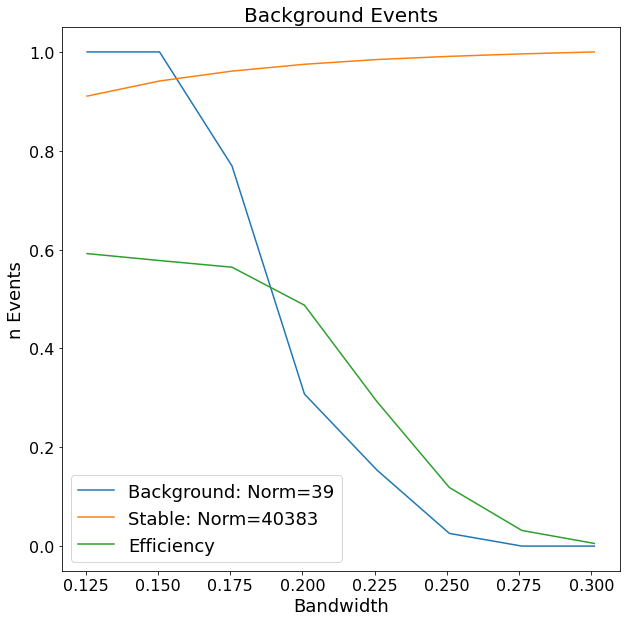

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(bandwidths, n_background / n_background.max(), label=f"Background: Norm={n_background.max()}")
ax.plot(bandwidths, n_stable / n_stable.max(), label=f"Stable: Norm={n_stable.max()}")
ax.plot(bandwidths, efficiency, label="Efficiency")
ax.set_title("Background Events", fontsize=20)
ax.set_ylabel("n Events", fontsize=18)
ax.set_xlabel("Bandwidth", fontsize=18)
ax.tick_params(labelsize=16)
ax.legend(fontsize=18)
fig.savefig(f"{fig_dir}bg_and_efficiency_v_KDEbandwidth.png")
plt.show(fig)

### Plot a few lightcurves bandwidths

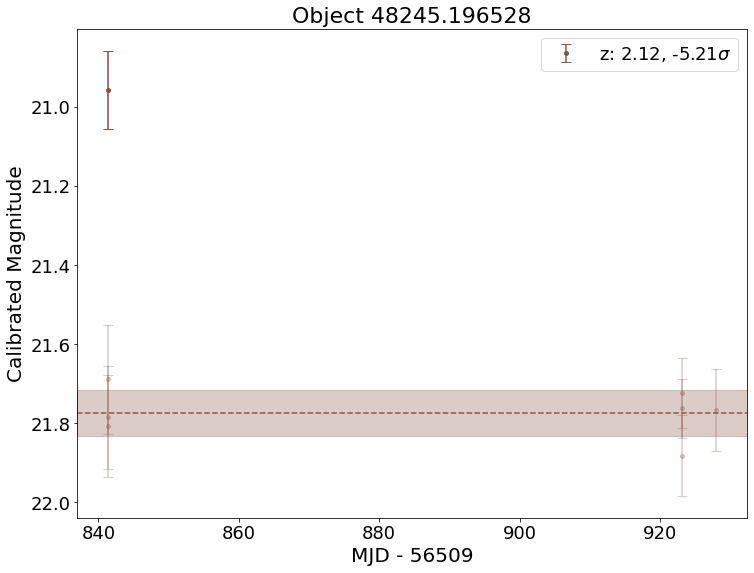

In [21]:
n_to_view = 10
for oid in trigger_ids:
    plot_lightcurve(lightcurve_df, oid)

### On what days do excursions occur?

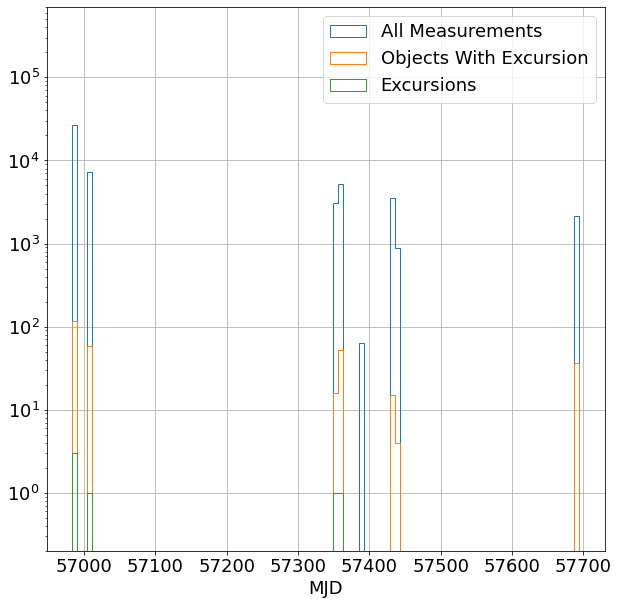

In [6]:
bins = np.linspace(lightcurve_df["mjd"].astype(int).min(), 
                   lightcurve_df["mjd"].astype(int).max() + 1, 100)
mjd_ex = lightcurve_df.loc[mask_excursion, "mjd"].astype(int)
mjd_all = lightcurve_df["mjd"].astype(int)
mjd_id = lightcurve_df.loc[mask_trigger_id, "mjd"].astype(int)

ax_mjd = mjd_all.hist(figsize=(10, 10), label="All Measurements",
                      histtype="step", stacked=True, log=True, bins=bins)
mjd_id.hist(figsize=(10, 10), label="Objects With Excursion",
            histtype="step", stacked=True, log=True, ax=ax_mjd, bins=bins)
mjd_ex.hist(figsize=(10, 10), label="Excursions",
            histtype="step", stacked=True, log=True, ax=ax_mjd, bins=bins)

fig = ax_mjd.get_figure()
ax_mjd.set_xlabel("MJD", fontsize=18)
ax_mjd.tick_params(labelsize=18)
ax_mjd.legend(fontsize=18, loc="upper right")
ax_mjd.set_ylim(0.2, 7e5)
# fig.savefig(f"{fig_dir}zp_mag_offsets_sample.png")
plt.show(fig)

### What's the stellaricity probability of my objects?

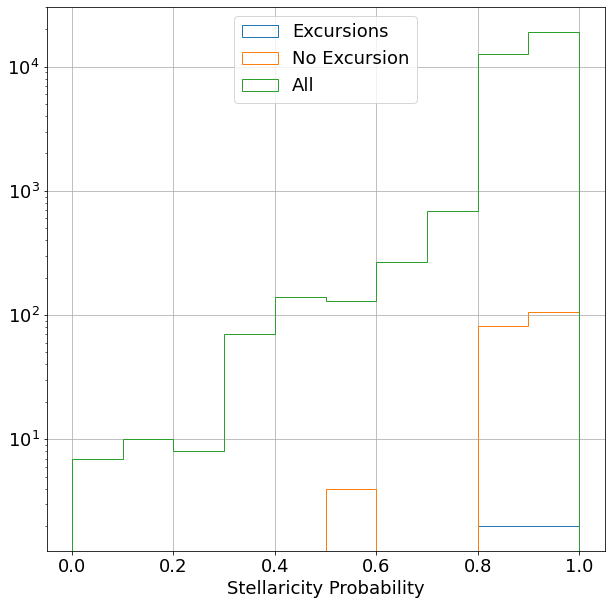

In [7]:
sextractor_mask = lightcurve_df["prob"] >= 0
trigger_probs = lightcurve_df.loc[mask_excursion & sextractor_mask, "prob"]
no_trigger_probs = lightcurve_df.loc[mask_trigger_id & ~mask_excursion & sextractor_mask, "prob"]
all_probs = lightcurve_df.loc[sextractor_mask, "prob"]

bins = np.linspace(0, 1, num=11)

ax = trigger_probs.hist(figsize=(10, 10), label="Excursions", bins=bins,
                        histtype="step", stacked=True, log=True)
no_trigger_probs.hist(figsize=(10, 10), label="No Excursion", bins=bins,
                      histtype="step", stacked=True, log=True, ax=ax)
all_probs.hist(figsize=(10, 10), label="All", bins=bins,
               histtype="step", stacked=True, log=True, ax=ax)

fig = ax.get_figure()
ax.set_xlabel("Stellaricity Probability", fontsize=18)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18, loc="upper center")
# fig.savefig(f"{fig_dir}zp_mag_offsets_sample.png")
plt.show(fig)

In [8]:
def gaussian(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

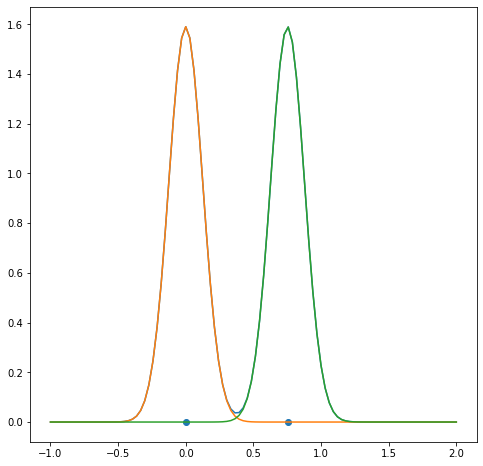

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))
samples = np.array([0, 2.5 * np.log10(2)]).reshape(-1, 1)
x = np.linspace(-1, 2, num=100)
bandwidth = 2.5 * np.log10(2) / 6
kde = KernelDensity(bandwidth=bandwidth).fit(samples)
y = np.exp(kde.score_samples(x.reshape(-1, 1)))
ax.plot(x, y)
ax.scatter(samples.reshape(-1), np.zeros((len(samples),)))
for s in samples:
    ax.plot(x, gaussian(x, s, bandwidth) / 2)
plt.show(fig)

0.9999999999997028


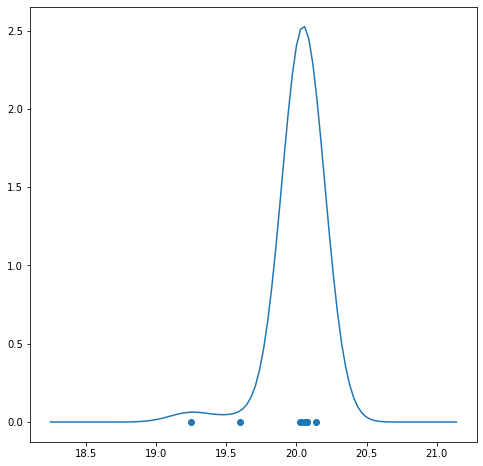

0.9999999999999284


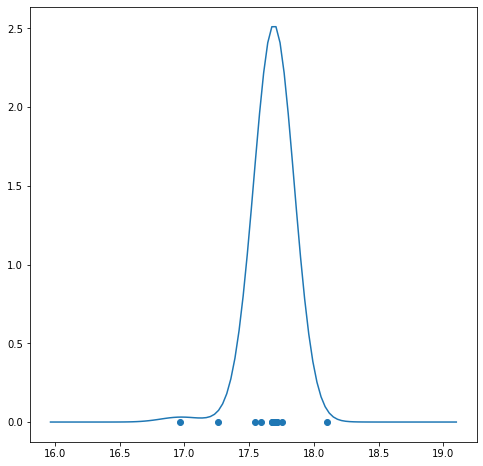

0.9999999999988247


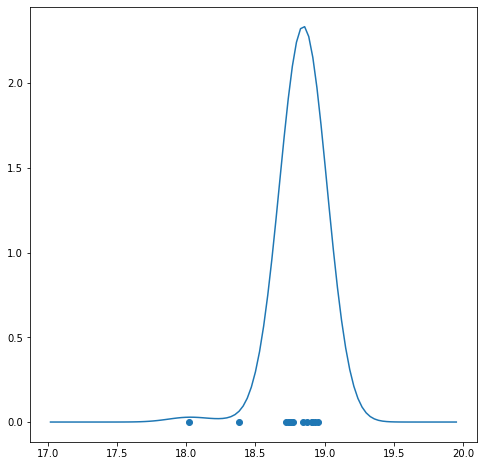

0.9999999999971164


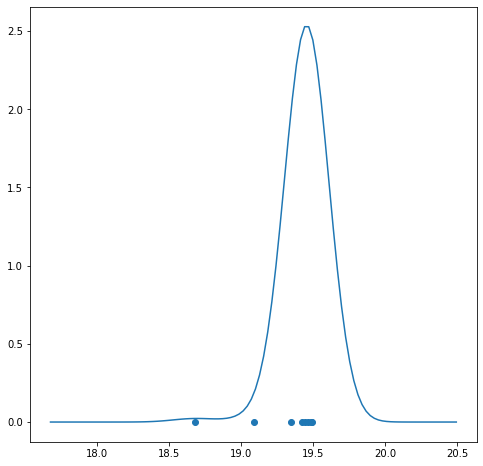

In [62]:
sussy_ids = [47553.582597, 47552.381918, 47553.1255022, 47552.131101]
sussy_filters = ['i', 'r', 'r', 'g']

for iid, f in zip(sussy_ids, sussy_filters):
    m1 = lightcurve_df["id"] == iid
    m2 = lightcurve_df["filter"] == f
    fig, ax = plt.subplots(figsize=(8, 8))
    vals = lightcurve_df.loc[m1 & m2, "cmag"].values.reshape(-1, 1)
    errs = lightcurve_df.loc[m1 & m2, "cerr"].values
    l = np.linspace(vals.min() - 1, vals.max() + 1, num=100)
    weights = np.power(errs, -2)
    kde = KernelDensity(bandwidth=2.5 * np.log10(2) / 5).fit(vals, sample_weight=weights)
    p = np.exp(kde.score_samples(l.reshape(-1, 1)))
    print(p.sum() * (l[1] - l[0]))
    ax.plot(l, p)
    ax.scatter(vals.reshape(-1), np.zeros((len(vals),)))
    plt.show(fig)

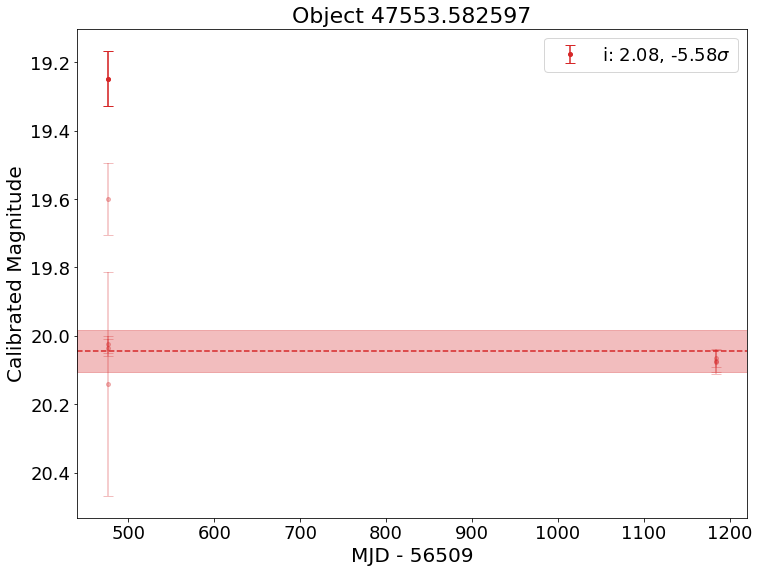

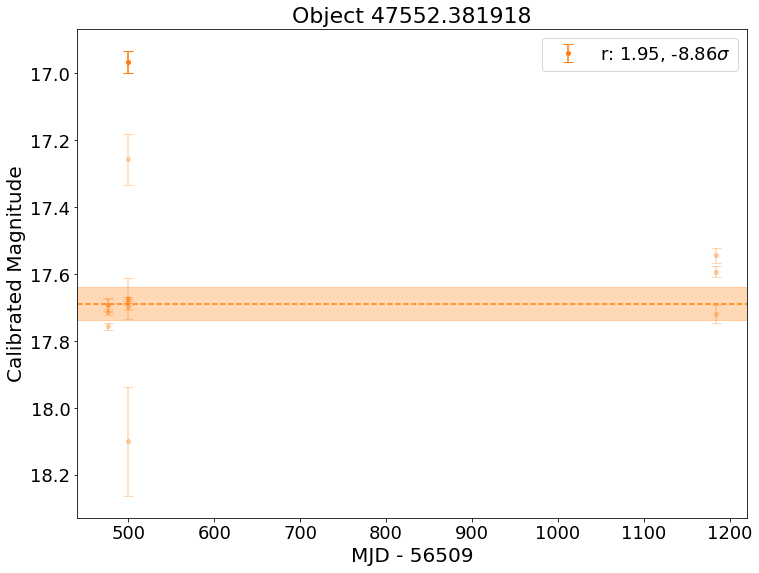

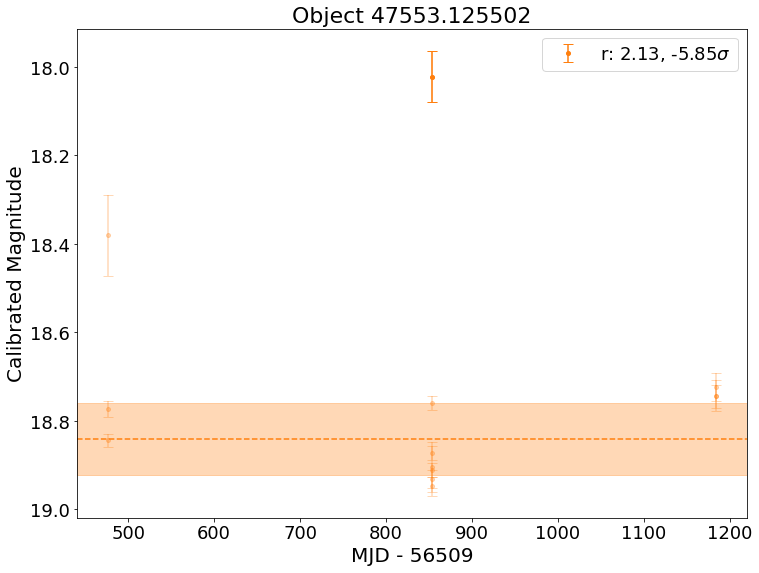

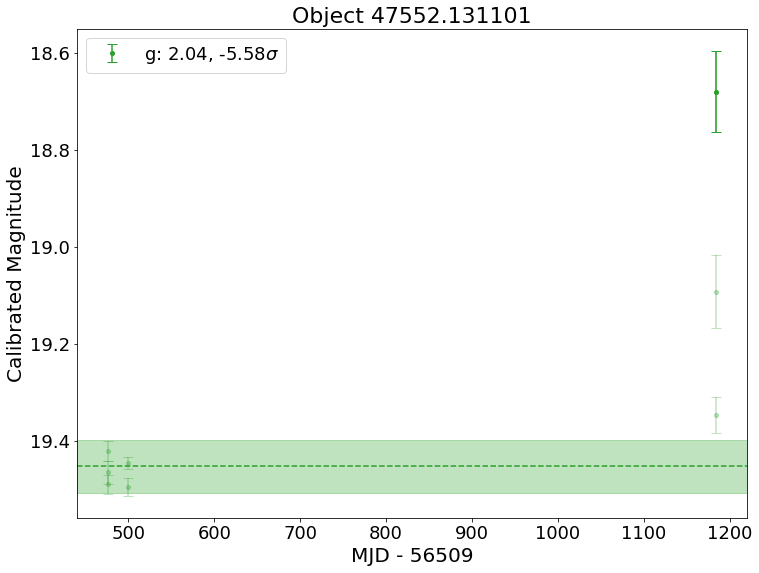

In [43]:
for iid in sussy_ids:
    plot_lightcurve(lightcurve_df, iid)

## Let's look at the images themselves

In [14]:
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/smash_dr2"
svc = sia.SIAService(DEF_ACCESS_URL)

object_id = trigger_ids[4]
mask_object_id = lightcurve_df["id"] == object_id
object_id_str = str(object_id).replace('.', '-')
filt = lightcurve_df.loc[mask_excursion & mask_object_id, "filter"].iloc[0]
mask_object_filter = lightcurve_df["filter"] == filt

obs_dates = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"] + 500000, decimals=8).astype(str)

image_ra = lightcurve_df.loc[mask_excursion & mask_object_id, "ra"].iloc[0]
image_dec = lightcurve_df.loc[mask_excursion & mask_object_id, "dec"].iloc[0]
image_fov = 0.001

imgTable = svc.search((image_ra, image_dec), 
                      (image_fov/np.cos(image_dec*np.pi/180), 
                       image_fov), verbosity=2).to_table()  # uses declination correction

select_filter = imgTable["obs_bandpass"] == filt
select_mjd = np.isin(imgTable["mjd_obs"].data.data, obs_dates)
select_proctype = imgTable["proctype"] == "InstCal"
select_prodtype = imgTable["prodtype"] == "image"
select = select_filter & select_mjd & select_proctype & select_prodtype
table = imgTable[select]
table

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_050417_ooi_r_v1.fits.fz&extn=19&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001",image/fits,354453,,,2,0,0,2,[2046 4094],,,[-0.13666],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_141124_050417_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_050417_ooi_r_v1.fits.fz&extn=19&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001&preview=true",,,79.637,-69.4945,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field41,1.31,SMASH DR2,30.9125,image,0.409,0,,267,,InstCal,2014-11-24T04:59:01.237262,556985.20765321,0
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_041234_ooi_r_v1.fits.fz&extn=19&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001",image/fits,343358,,,2,0,0,2,[2046 4094],,,[-0.13672],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_141124_041234_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141124_041234_ooi_r_v1.fits.fz&extn=19&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001&preview=true",,,79.6169,-69.4932,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field41,1.35,SMASH DR2,28.821,image,0.518,0,,30,,InstCal,2014-11-24T04:11:18.130006,556985.17451539,0
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141218_053557_ooi_r_v1.fits.fz&extn=37&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001",image/fits,359828,,,2,0,0,2,[2046 4094],,,[-0.11955],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_141218_053557_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141218_053557_ooi_r_v1.fits.fz&extn=37&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001&preview=true",,,79.5015,-69.3745,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,Field36,1.32,SMASH DR2,31.088,image,0.437,0,,267,,InstCal,2014-12-18T05:30:44.364760,557009.22968015,0
smash_dr2,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141218_050448_ooi_r_v1.fits.fz&extn=43&POS=79.49981733209168,-69.44537575071018&SIZE=0.0028481896142227834,0.001",image/fits,350170,,,2,0,0,2,[2046 4094],,,[-0.1212],,smash_dr2,,SMASH DR2,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_smash_dr2.siav1:ivo://datalab.noao/smash_dr2/c4d_141218_050448_ooi_r_v1.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=smash_dr2&siaRef=c4d_141218_050448_ooi_r_v1.fits.fz&extn=43&POS=79.49981733209168,-69.44537575071018&SIZ

### InstCal images

Exposure time: 30s


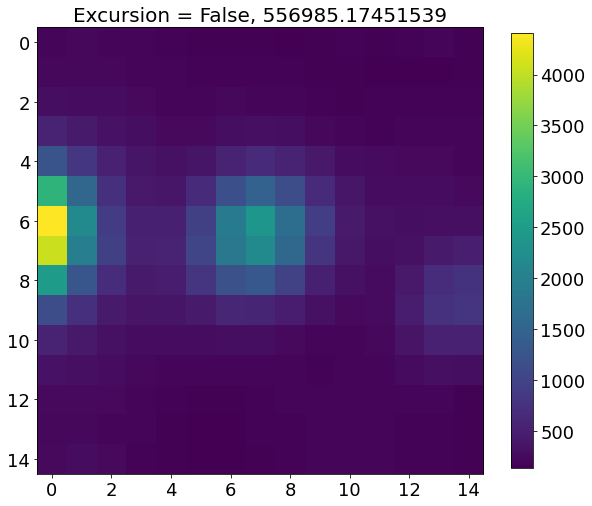

Exposure time: 60s


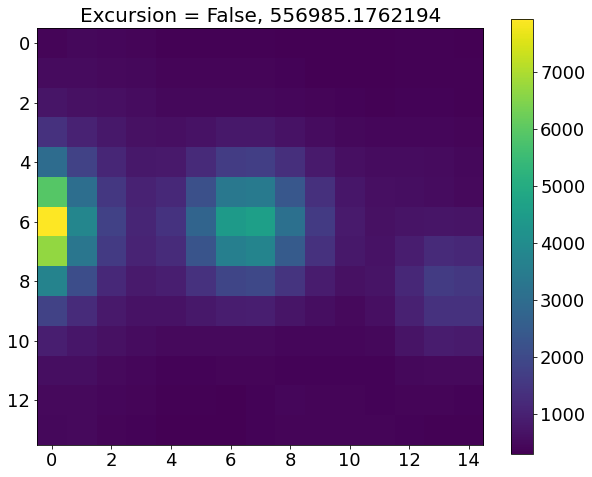

Exposure time: 60s


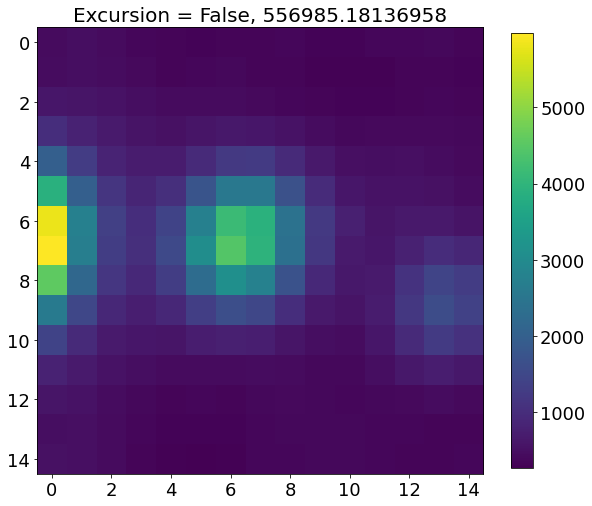

Exposure time: 267s


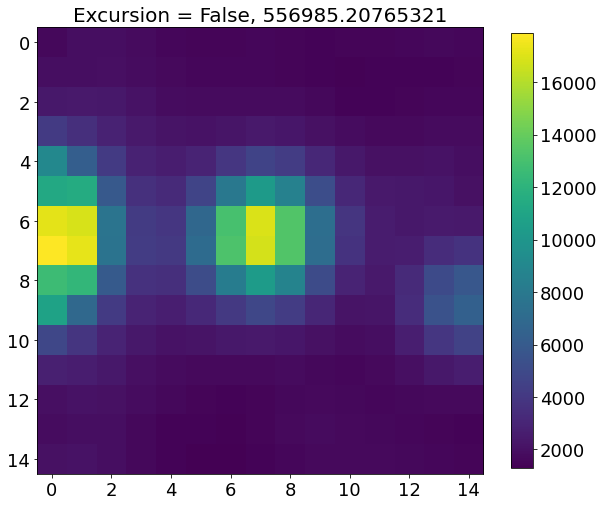

Exposure time: 30s


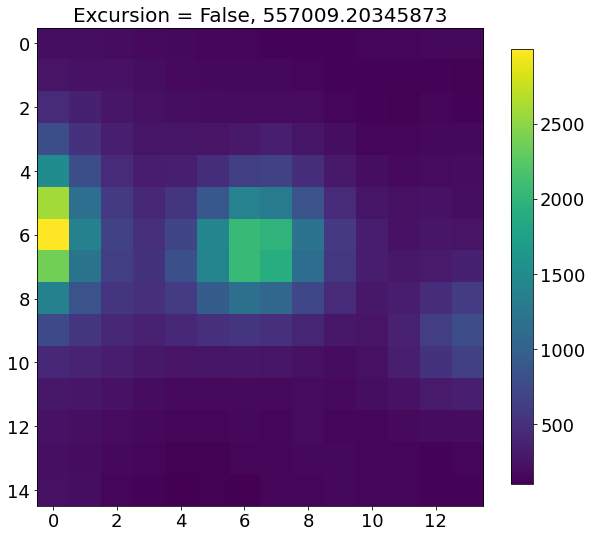

Exposure time: 60s


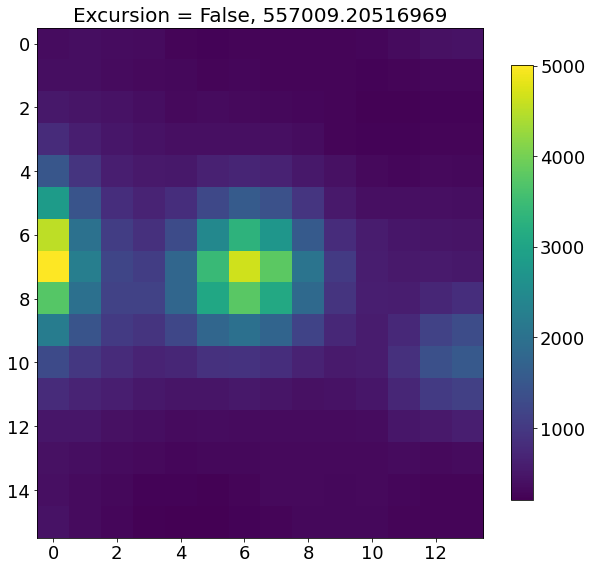

Exposure time: 60s


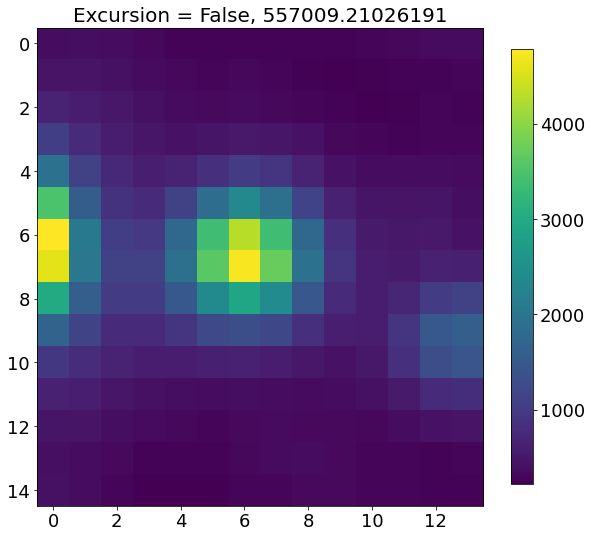

Exposure time: 60s


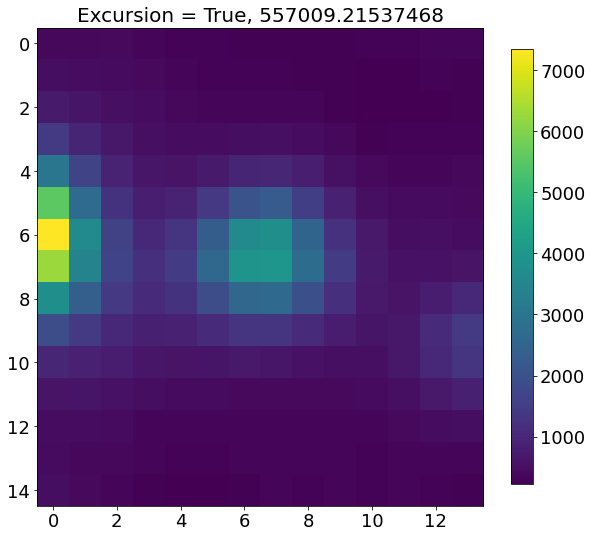

Exposure time: 267s


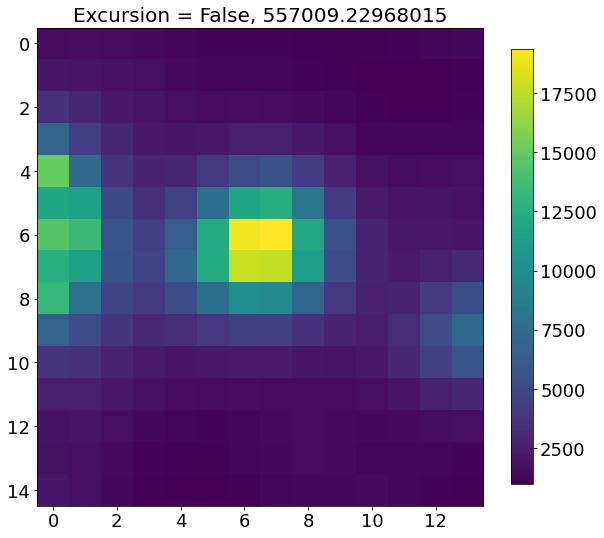

Exposure time: 267s


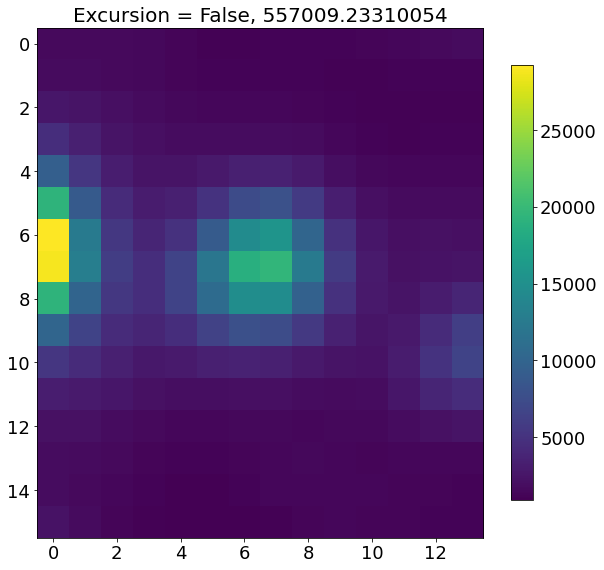

Exposure time: 267s


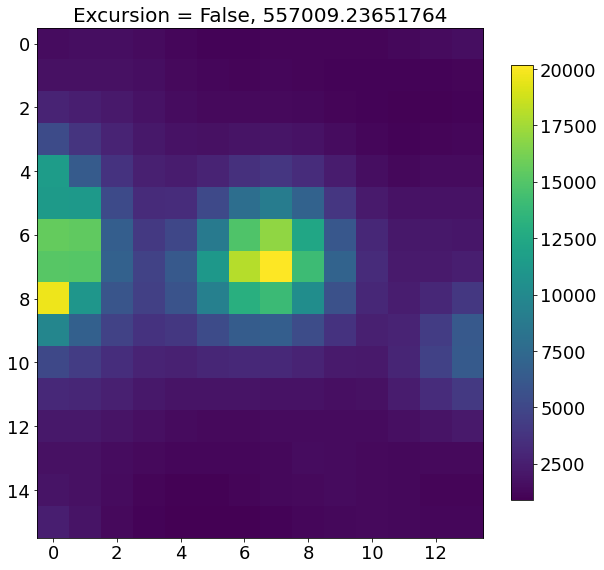

Exposure time: 267s


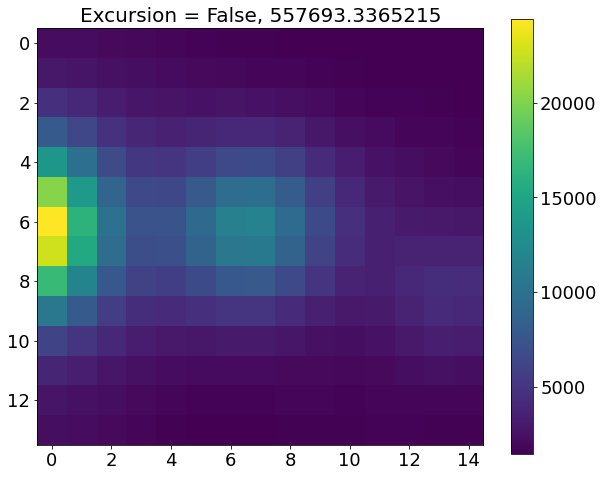

Exposure time: 267s


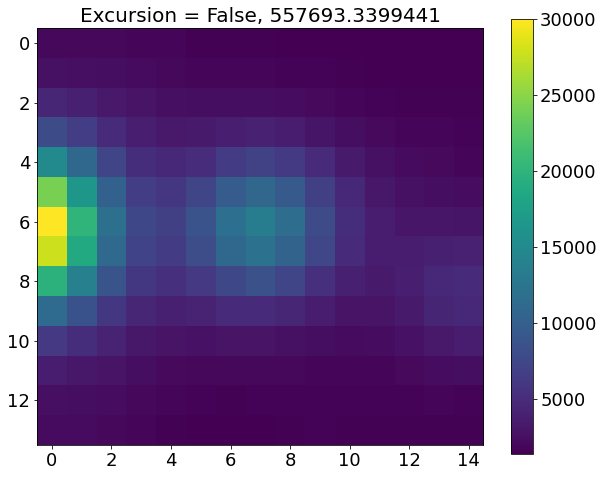

Exposure time: 267s


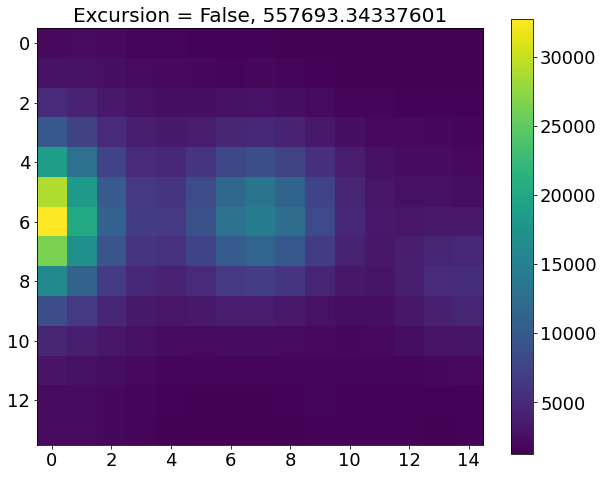

In [15]:
images = []
exposure_times = []

for date in np.sort(table["mjd_obs"].data.data):
    row = table[table["mjd_obs"] == date][0]
    mask_object_date = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"] + 500000, 
                                decimals=8).astype(str) == date
    excursion = lightcurve_df.loc[mask_object_id & mask_object_filter & mask_object_date, "excursion"].iloc[0]
    url = row["access_url"]
    exposure_time = row["exptime"]
    print(f"Exposure time: {exposure_time}s")
    file = utils.data.download_file(url, cache=True, timeout=300)
    im = io.fits.getdata(file)
    fig, ax = plt.subplots(figsize=(10, 10))
    axim = ax.imshow(im)
    cbar = fig.colorbar(axim, ax=ax, shrink=0.8)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Excursion = {excursion}, {date}", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    images.append(im)
    exposure_times.append(exposure_time)
    plt.show(fig)

### InstCal scaled by exposure time

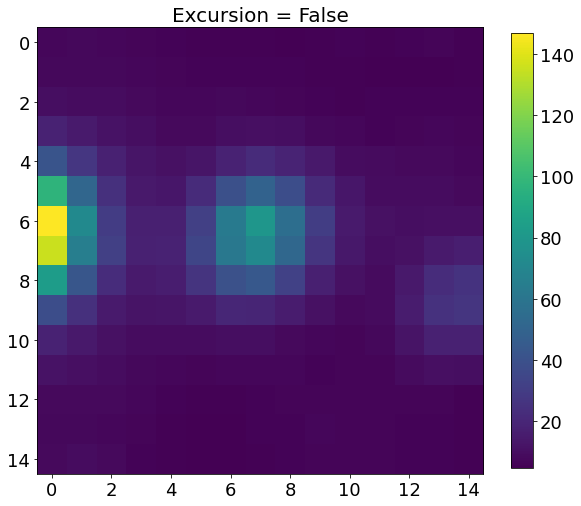

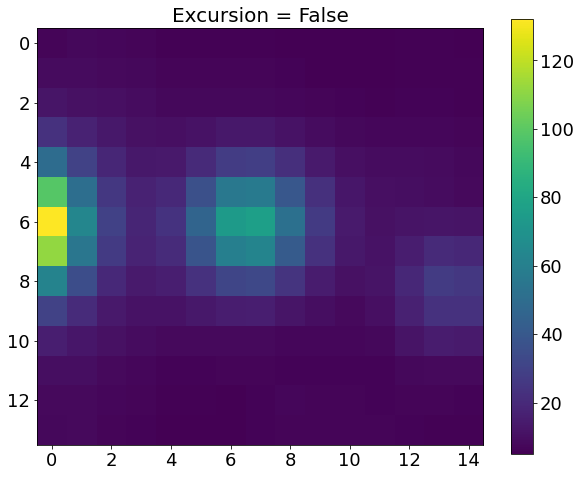

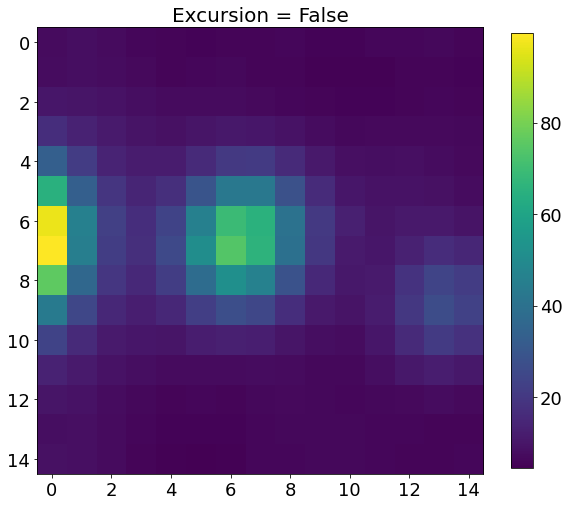

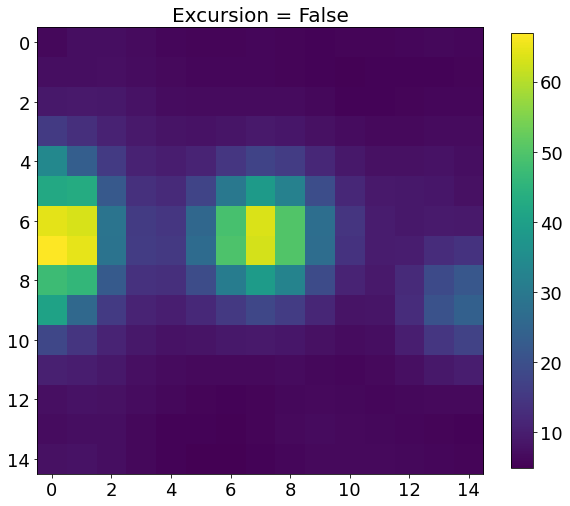

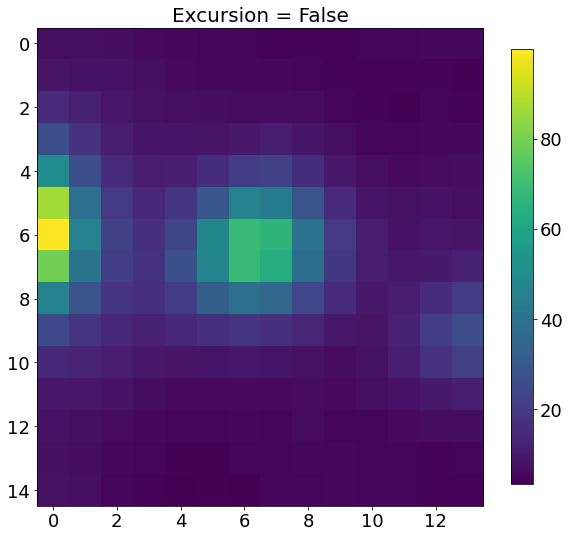

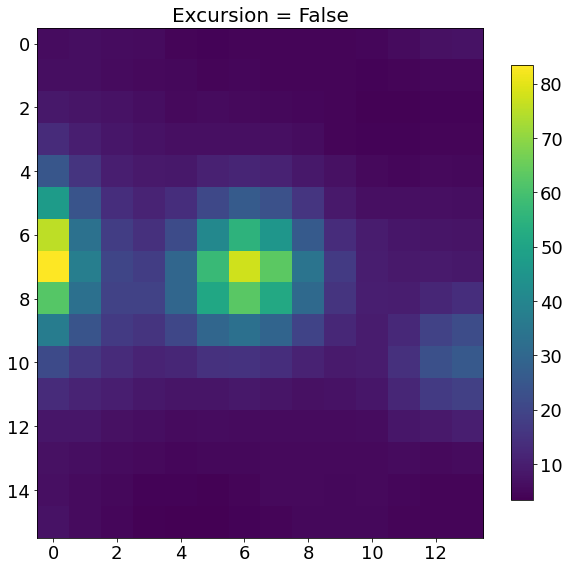

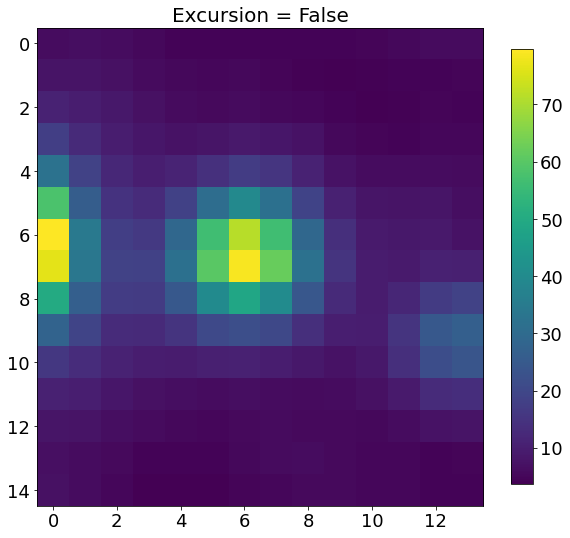

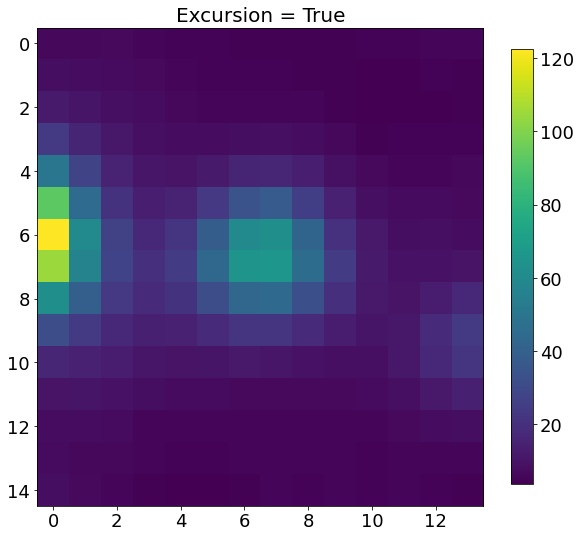

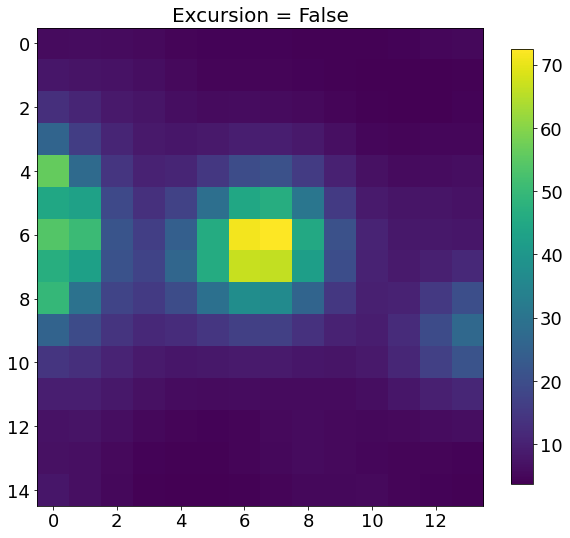

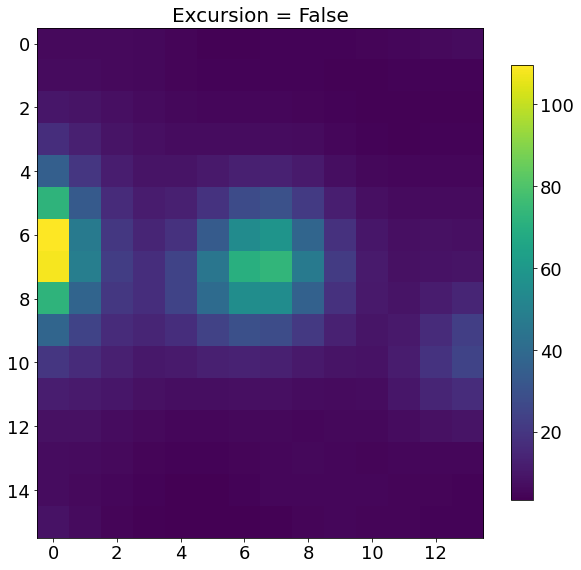

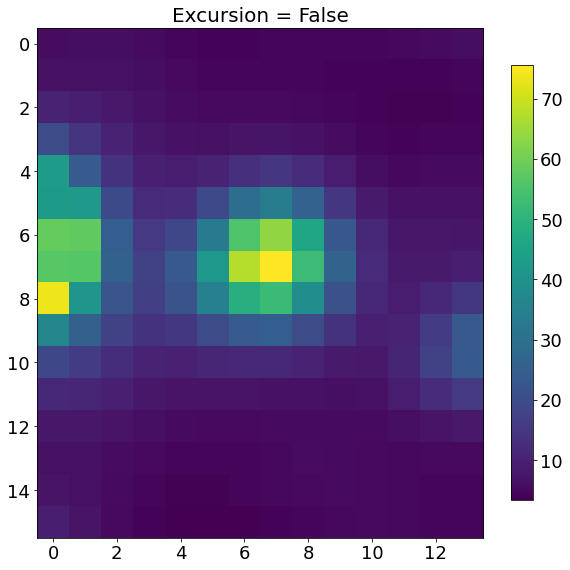

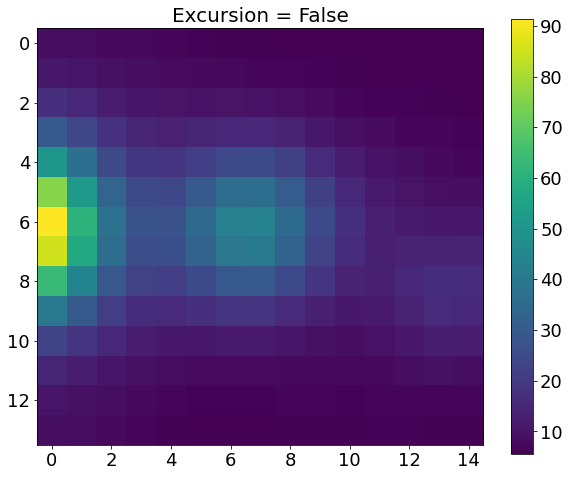

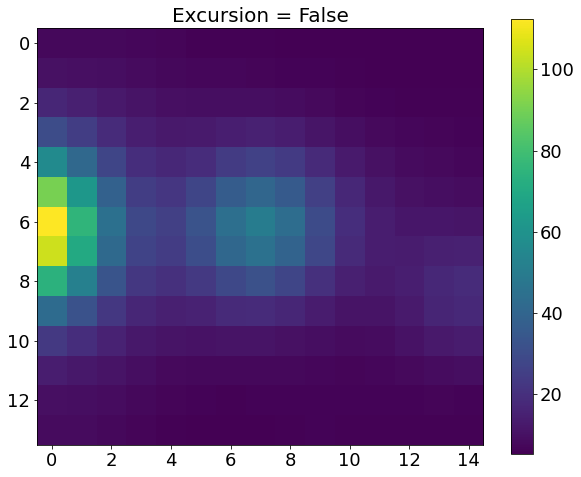

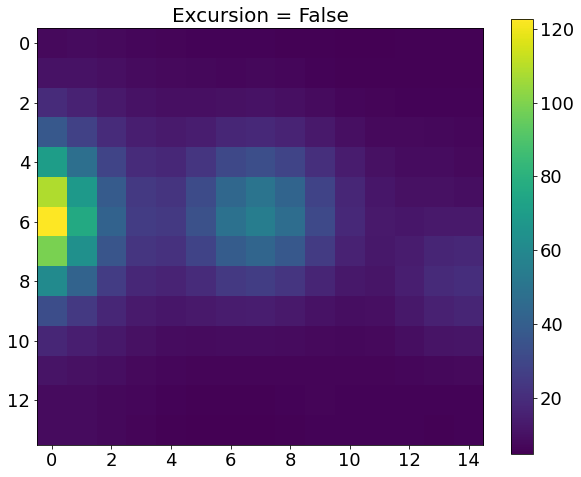

In [16]:
for i, date in enumerate(np.sort(table["mjd_obs"].data.data)):
    row = table[table["mjd_obs"] == date][0]
    mask_object_date = np.round(lightcurve_df.loc[mask_object_id & mask_object_filter, "mjd"] + 500000, 
                                decimals=8).astype(str) == date
    excursion = lightcurve_df.loc[mask_object_id & mask_object_filter & mask_object_date, "excursion"].iloc[0]
    exposure_time = exposure_times[i]
    im = images[i] / int(exposure_time)
    fig, ax = plt.subplots(figsize=(10, 10))
    axim = ax.imshow(im)
    cbar = fig.colorbar(axim, ax=ax, shrink=0.8)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Excursion = {excursion}", fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.show(fig)
    fig.savefig(f"{fig_dir}{object_id_str}_image_exptime_scaled{i}.png")

### What's the dataframe for this object look like?

In [73]:
print(lightcurve_df.loc[mask_object_filter & mask_object_id, ["mjd", "cmag", "mag", "zpcalibflag",
                                                              "calib_zpterm", "exptime", "apcor"]].sort_values(by=["mjd"]))

                mjd       cmag     mag  zpcalibflag  calib_zpterm  exptime  \
18916  56985.174515  19.089025  15.018            2     -0.349500       30   
18918  56985.176219  18.845715  14.011            2     -0.406096       60   
18914  56985.181370  18.224636  13.218            2     -0.466372       60   
18910  57693.336522  18.930456  12.574            2     -0.318202      267   
18909  57693.339944  18.937155  12.549            2     -0.365502      267   
18911  57693.343376  18.909750  12.523            2     -0.356589      267   

          apcor  
18916 -0.028721  
18918  0.016760  
18914 -0.094886  
18910 -0.023921  
18909 -0.015667  
18911 -0.022288  


### Plot the quotient images

In [74]:
for im in images:
    print(im.shape)

(14, 14)
(15, 14)
(15, 15)
(14, 15)
(14, 14)
(15, 14)


In [75]:
quotient_images = [images[3] / images[4]]
quotient_times = [float(exposure_times[3]) / float(exposure_times[4])]

for i, (q_image, q_exp_time) in enumerate(zip(quotient_images, quotient_times)):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axim = axes[0].imshow(q_image, vmin=0, vmax=3)
    cbar = fig.colorbar(axim, ax=axes[0], shrink=0.8)
    cbar.ax.tick_params(labelsize=18)
    axes[0].set_title("Quotient Image", fontsize=22)
    axes[1].hist(q_image.flatten(), bins=40)
    axes[1].axvline(q_exp_time, c='k', ls="--")
    axes[1].set_title("Pixel Quotient Value", fontsize=22)

    for ax in axes.ravel():
        ax.tick_params(labelsize=18)
    plt.show(fig)
#     fig.savefig(f"{fig_dir}{object_id_str}_quotient_image{i}.png")

ValueError: operands could not be broadcast together with shapes (14,15) (14,14) 

## Plot the lightcurve for this object.

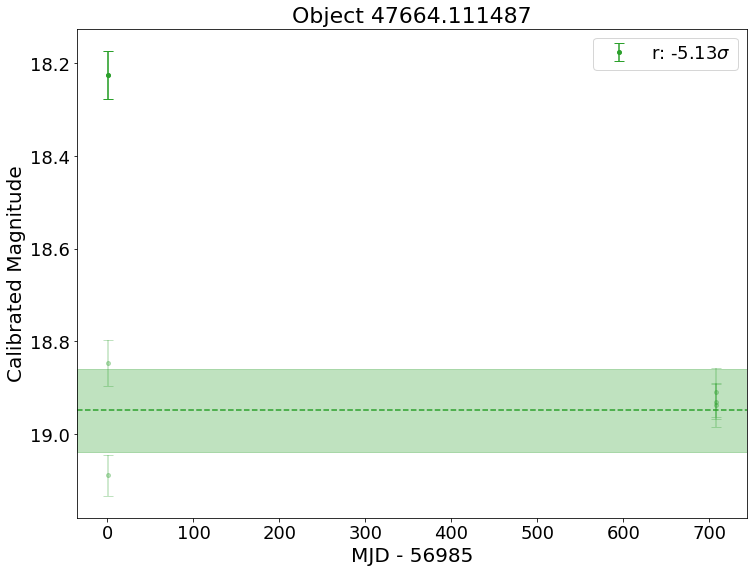

In [76]:
plot_lightcurve(lightcurve_df, object_id, savefig=True)

### Histogram of Delta Mags

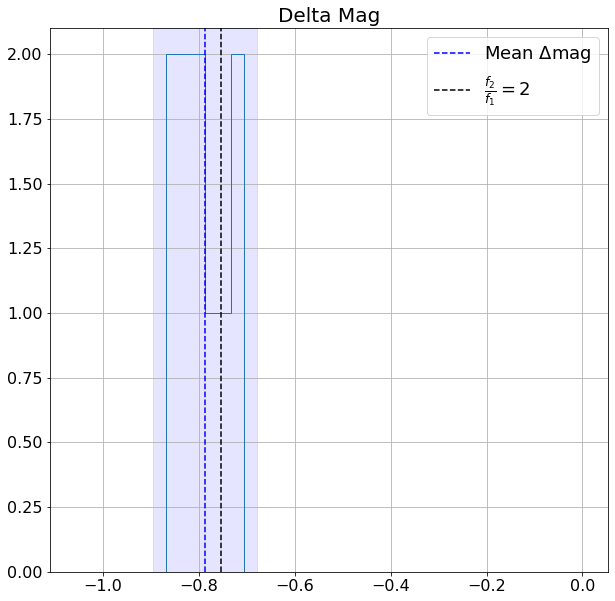

In [21]:
n_excursions = len(excursion_df)
d = {"delta_mag": np.zeros((n_excursions)), "delta_mag_err": np.zeros((n_excursions))}
delta_mag_df = pd.DataFrame(data=d)

for i, row in enumerate(excursion_df.itertuples()):
    mask_id = lightcurve_df["id"] == row.id
    source_lc_df = lightcurve_df.loc[mask_id]
    filters_with_excursion = source_lc_df.loc[source_lc_df["excursion"], "filter"]
    
    for f in filters_with_excursion:
        m = filters == f
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        mask_exc = mask & lightcurve_df["excursion"]
        lightcurve_full = lightcurve_df.loc[mask]
        lightcurve_exc = lightcurve_df.loc[mask_exc]
        vals = lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "cmag"].values
        weights = (lightcurve_df.loc[(mask & ~lightcurve_df["excursion"]), "cerr"].values)**-2
        w_mean = (weights * vals).sum() / weights.sum()
        w_sigma = np.sqrt(1 / weights.sum())
        delta_mag_df.at[i, "delta_mag"] = lightcurve_exc["cmag"].values[0] - w_mean
        delta_mag_df.at[i, "delta_mag_err"] = lightcurve_exc["cerr"].values[0] + w_sigma

delta_mag = delta_mag_df["delta_mag"].values
weights = np.power(delta_mag_df["delta_mag_err"].values, -2)
delta_mag_wmean = (delta_mag * weights).sum() / weights.sum()
delta_mag_wsigma = delta_mag_df["delta_mag_err"].mean()

flux_doubling = -2.5 * np.log10(2)

hist_bins = np.linspace(delta_mag_df["delta_mag"].min() - 0.2, 0, num=40)
hist = delta_mag_df.hist(column="delta_mag", xlabelsize=16, ylabelsize=16, 
                         figsize=(10, 10), bins=hist_bins, histtype="step")[0, 0]
fig = hist.get_figure()
hist.set_title("Delta Mag", fontsize=20)
hist.axvline(delta_mag_wmean, linestyle="--", color='b', label=r"Mean $\Delta$mag")
hist.axvline(flux_doubling, linestyle="--", color='k', label=r"$\frac{f_2}{f_1} = 2$")
hist.axvspan(delta_mag_wmean - delta_mag_wsigma,
              delta_mag_wmean + delta_mag_wsigma, alpha=0.1, color='b')
hist.legend(loc="upper right", fontsize=18)
plt.show(fig)
# fig.savefig(f"{fig_dir}delta_mag_hist1.png")

# Gaia

In [44]:
gaia_search_radius = 2
gaia_bands = np.array(["RP", "G", "BP"])

gaia_sub_query = f"""
SELECT source_id FROM gaia_dr2.gaia_source
    WHERE 't' = Q3C_RADIAL_QUERY(ra, dec, {lmc_ra}, {lmc_dec}, {gaia_search_radius})
        AND parallax_over_error != 'NaN'
"""

gaia_query = f"""
SELECT GLC.band, GLC.time, GLC.flux, GLC.flux_error, 
    GLC.mag, GLC.source_id, GS.parallax, GS.parallax_error, GS.parallax_over_error
    FROM (
        SELECT * FROM gaia_dr2.light_curves AS LC
            WHERE LC.source_id IN ({gaia_sub_query})) AS GLC
    INNER JOIN gaia_dr2.gaia_source as GS
        ON GLC.source_id = GS.source_id
"""

gaia_lightcurve_df = qc.query(sql=gaia_query, fmt="pandas")

In [82]:
mask_filters = np.array([gaia_lightcurve_df["band"] == b for b in gaia_bands])
gaia_lightcurve_df["excursion"] = False

for source_id in gaia_lightcurve_df["source_id"].unique():
    mask_id = gaia_lightcurve_df["source_id"] == source_id

    for mask_filter in mask_filters:
        mask = mask_id & mask_filter
        lc = gaia_lightcurve_df.loc[mask]
        n_samples = len(lc)

        if n_samples >= n_detections:
            samples = -2.5 * np.log10(lc["flux"].values)
            errs = (2.5 * lc["flux_error"] / (np.log(10) * lc["flux"])).values
            gaia_lightcurve_df.loc[mask, "excursion"] = detect_excursions(samples, errs)

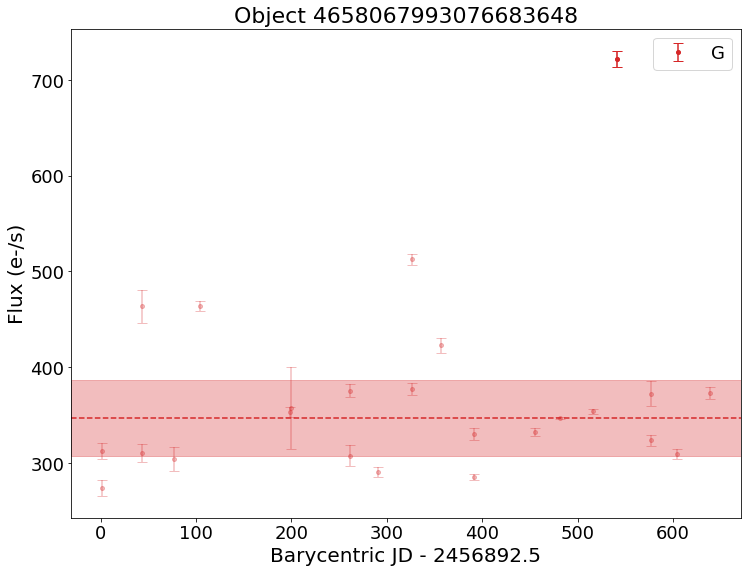

In [88]:
gaia_colors = np.array(["tab:blue", "tab:red", "tab:green"])
gaia_detected_ids = gaia_lightcurve_df.loc[gaia_lightcurve_df["excursion"], "source_id"].unique()
min_time = gaia_lightcurve_df["time"].astype(int).min()
time_offset = min_time + 2455197.5

for oid in gaia_detected_ids:
    fig, ax = plt.subplots(figsize=(12, 9))

    oid_str = str(oid).replace('.', '-')
    mask_id = gaia_lightcurve_df["source_id"] == oid
    source_lc_df = gaia_lightcurve_df.loc[mask_id]
    filters_with_excursion = source_lc_df.loc[source_lc_df["excursion"], "band"]
    
    for f in filters_with_excursion:
        m = gaia_bands == f
        c = gaia_colors[m][0]
        mask_filter = mask_filters[m]
        mask = mask_id & mask_filter
        mask_exc = mask & gaia_lightcurve_df["excursion"]
        
        gaia_lightcurve_full = gaia_lightcurve_df.loc[mask]

        gaia_lightcurve_exc = gaia_lightcurve_df.loc[mask_exc]
        
        vals = gaia_lightcurve_df.loc[(mask & ~gaia_lightcurve_df["excursion"]), "flux"].values
        errs = gaia_lightcurve_df.loc[(mask & ~gaia_lightcurve_df["excursion"]), "flux_error"].values
        weights = np.power(errs, -2)
        w_mean = weighted_mean(vals, weights)
        w_sigma = weighted_std(vals, weights)

        ax.errorbar(gaia_lightcurve_full["time"] - min_time, gaia_lightcurve_full['flux'], 
                    yerr=gaia_lightcurve_full["flux_error"],
                    marker='.', ms=8, capsize=5, color=c, ls="None", alpha=0.3)

        ax.errorbar(gaia_lightcurve_exc["time"] - min_time, gaia_lightcurve_exc['flux'], 
                    yerr=gaia_lightcurve_exc["flux_error"],
                    marker='.', ms=8, capsize=5, color=c, 
                    label=f"{f}", ls="None")
        
        ax.axhline(w_mean, color=c, linestyle='--')
        ax.axhspan(w_mean - w_sigma, w_mean + w_sigma, color=c, alpha=0.3)

    ax.set_xlabel(f'Barycentric JD - {time_offset}', fontsize=20)
    ax.set_ylabel('Flux (e-/s)', fontsize=20)
    ax.legend(fontsize=18)
    ax.tick_params(labelsize=18)
    ax.set_title(f"Object {oid}", fontsize=22)
    fig.savefig(f"{fig_dir}gaia_{oid_str}_kde_detection_lightcurve.png")
    plt.show(fig)